In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Load Data ---
data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\mixed_filtered.csv")

# --- Split Train and Test ---
train_data = data[data['fuel_type'] != 'digestate_pe']
test_data = data[data['fuel_type'] == 'digestate_pe']

X_train = train_data.drop(columns=['Unnamed: 0', 'sample', 'devol_yield'])
y_train = train_data['devol_yield']

X_test = test_data.drop(columns=['Unnamed: 0', 'sample', 'devol_yield'])
y_test = test_data['devol_yield']

# --- One-Hot Encode All Categorical Columns ---
X_all = pd.concat([X_train, X_test], axis=0)
X_all_encoded = pd.get_dummies(X_all, columns=['fuel_type', 'fuel_category'], drop_first=True)

X_train_encoded = X_all_encoded.iloc[:len(X_train), :].copy()
X_test_encoded = X_all_encoded.iloc[len(X_train):, :].copy()

# --- Scale Numerical Features ---
numerical_cols = X_train_encoded.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])
X_test_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

# --- Base Models ---
base_models = [
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=2000, random_state=42),
    LGBMRegressor(random_state=42),
    XGBRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define random search distributions for hyperparameters
param_dist_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50), (200,)],
    'activation': ['relu', 'tanh'],
    'alpha': uniform(0.01, 0.1),
    'learning_rate_init': uniform(0.01, 0.1),
    'max_iter': [1000, 2000, 4000],
}

param_dist_lgbm = {
    'n_estimators': [200, 400],
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(5, 9),
}

param_dist_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 7),
}

param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 7),
}

# RandomizedSearch for each base model
random_search_mlp = RandomizedSearchCV(MLPRegressor(random_state=42), param_dist_mlp, n_iter=100, cv=5, n_jobs=-1, verbose=2)
random_search_lgbm = RandomizedSearchCV(LGBMRegressor(random_state=42), param_dist_lgbm, n_iter=100, cv=5, n_jobs=-1, verbose=2)
random_search_xgb = RandomizedSearchCV(XGBRegressor(random_state=42), param_dist_xgb, n_iter=100, cv=5, n_jobs=-1, verbose=2)
random_search_gb = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_dist_gb, n_iter=100, cv=5, n_jobs=-1, verbose=2)

# Fit and get the best models
random_search_mlp.fit(X_train_encoded, y_train)
random_search_lgbm.fit(X_train_encoded, y_train)
random_search_xgb.fit(X_train_encoded, y_train)
random_search_gb.fit(X_train_encoded, y_train)

best_mlp = random_search_mlp.best_estimator_
best_lgbm = random_search_lgbm.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_gb = random_search_gb.best_estimator_


# --- Generate Meta Features via K-Fold ---
meta_features = np.zeros((X_train_encoded.shape[0], len(base_models)))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, model in enumerate([best_mlp, best_lgbm, best_xgb, best_gb]):  # Use the best tuned models for each base model
    for train_idx, val_idx in kf.split(X_train_encoded):
        X_tr, X_val = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]

        model_clone = clone(model)
        model_clone.fit(X_tr, y_tr)
        meta_features[val_idx, i] = model_clone.predict(X_val)

# --- Train Meta-Model ---
meta_model = Ridge()
meta_model.fit(meta_features, y_train)

# --- Train Base Models on Full Data ---
for model in [best_mlp, best_lgbm, best_xgb, best_gb]:
    model.fit(X_train_encoded, y_train)

# --- Predict on Test Set ---
meta_test_features = np.column_stack([model.predict(X_test_encoded) for model in [best_mlp, best_lgbm, best_xgb, best_gb]])

# --- Final Prediction ---
y_pred_stack = meta_model.predict(meta_test_features)

# --- Evaluate the Model ---
mse = mean_squared_error(y_test, y_pred_stack)
r2 = r2_score(y_test, y_pred_stack)

print("MSE on Test Set:", mse)
print("R² on Test Set:", r2)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\demir\PycharmProjects\volatile-predict\.venv\lib\site-packages\sklearn\model_selection\_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 183, number of used features: 17
[LightGBM] [Info] Start training from score 49.542942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [49]:
test_data['predicted_devol_yield'] = y_pred_stack

C:\Users\demir\AppData\Local\Temp\ipykernel_17576\2760143195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_devol_yield'] = y_pred_stack


In [50]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mae = mean_absolute_error(y_test, y_pred_stack)
print(f'RMSE on Test Set: {rmse}')
print(f'MAE on Test Set: {mae}')

RMSE on Test Set: 7.755938416855704
MAE on Test Set: 6.399761823111388


C:\Users\demir\AppData\Local\Temp\ipykernel_17576\620771195.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_devol_yield'] = y_pred_stack


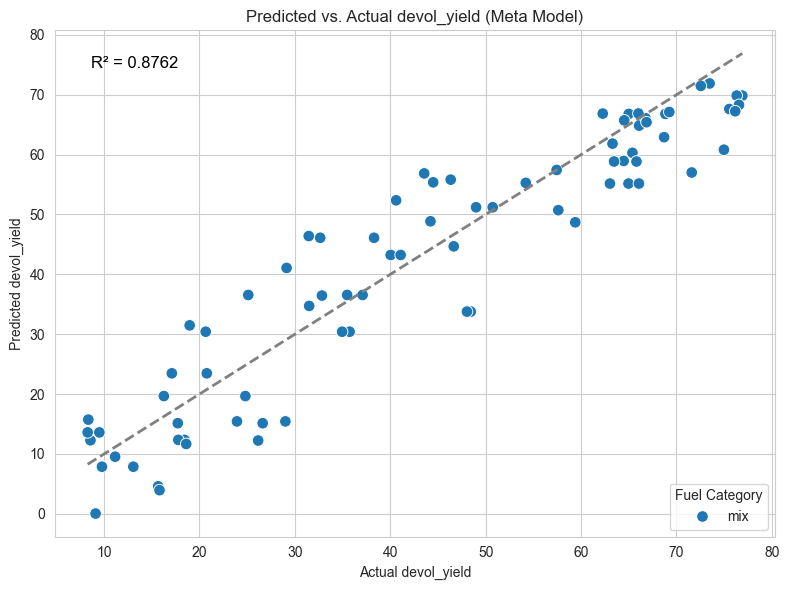

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² score
r2 = r2_score(y_test, y_pred_stack)

# Add predictions to the test dataframe
test_data['predicted_devol_yield'] = y_pred_stack

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(data=test_data, x='devol_yield', y='predicted_devol_yield', hue='fuel_category', s=70)
plt.plot([test_data['devol_yield'].min(), test_data['devol_yield'].max()],
         [test_data['devol_yield'].min(), test_data['devol_yield'].max()],
         color='gray', linestyle='--', linewidth=2)

# Add R² score as text
plt.text(0.05, 0.95, f"R² = {r2:.4f}", ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')

# Add labels and title
plt.xlabel('Actual devol_yield')
plt.ylabel('Predicted devol_yield')
plt.title('Predicted vs. Actual devol_yield (Meta Model)')
plt.legend(title='Fuel Category')
plt.grid(True)
plt.tight_layout()
plt.show()


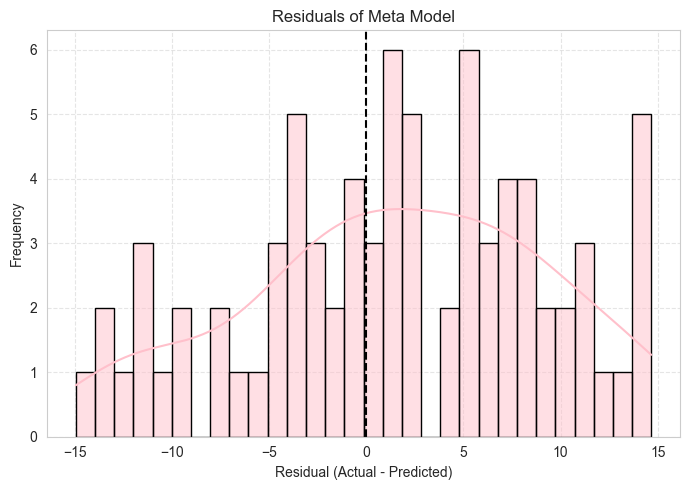

In [52]:
residuals_stack = y_test - y_pred_stack

plt.figure(figsize=(7, 5))
sns.histplot(residuals_stack, bins=30, kde=True, color="pink", edgecolor="black")
plt.axvline(0, color='k', linestyle='--')
plt.title("Residuals of Meta Model")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


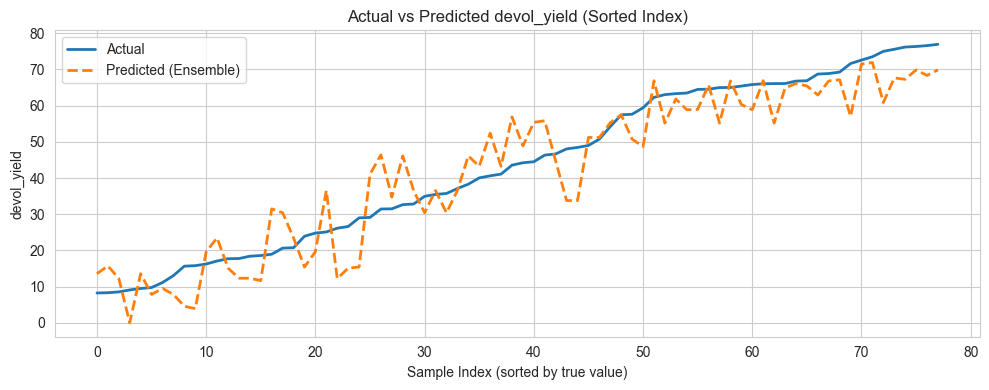

In [53]:
sorted_idx = np.argsort(y_test.values)
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[sorted_idx], label="Actual", linewidth=2)
plt.plot(y_pred_stack[sorted_idx], label="Predicted (Ensemble)", linestyle='--', linewidth=2)
plt.legend()
plt.title("Actual vs Predicted devol_yield (Sorted Index)")
plt.xlabel("Sample Index (sorted by true value)")
plt.ylabel("devol_yield")
plt.grid(True)
plt.tight_layout()
plt.show()

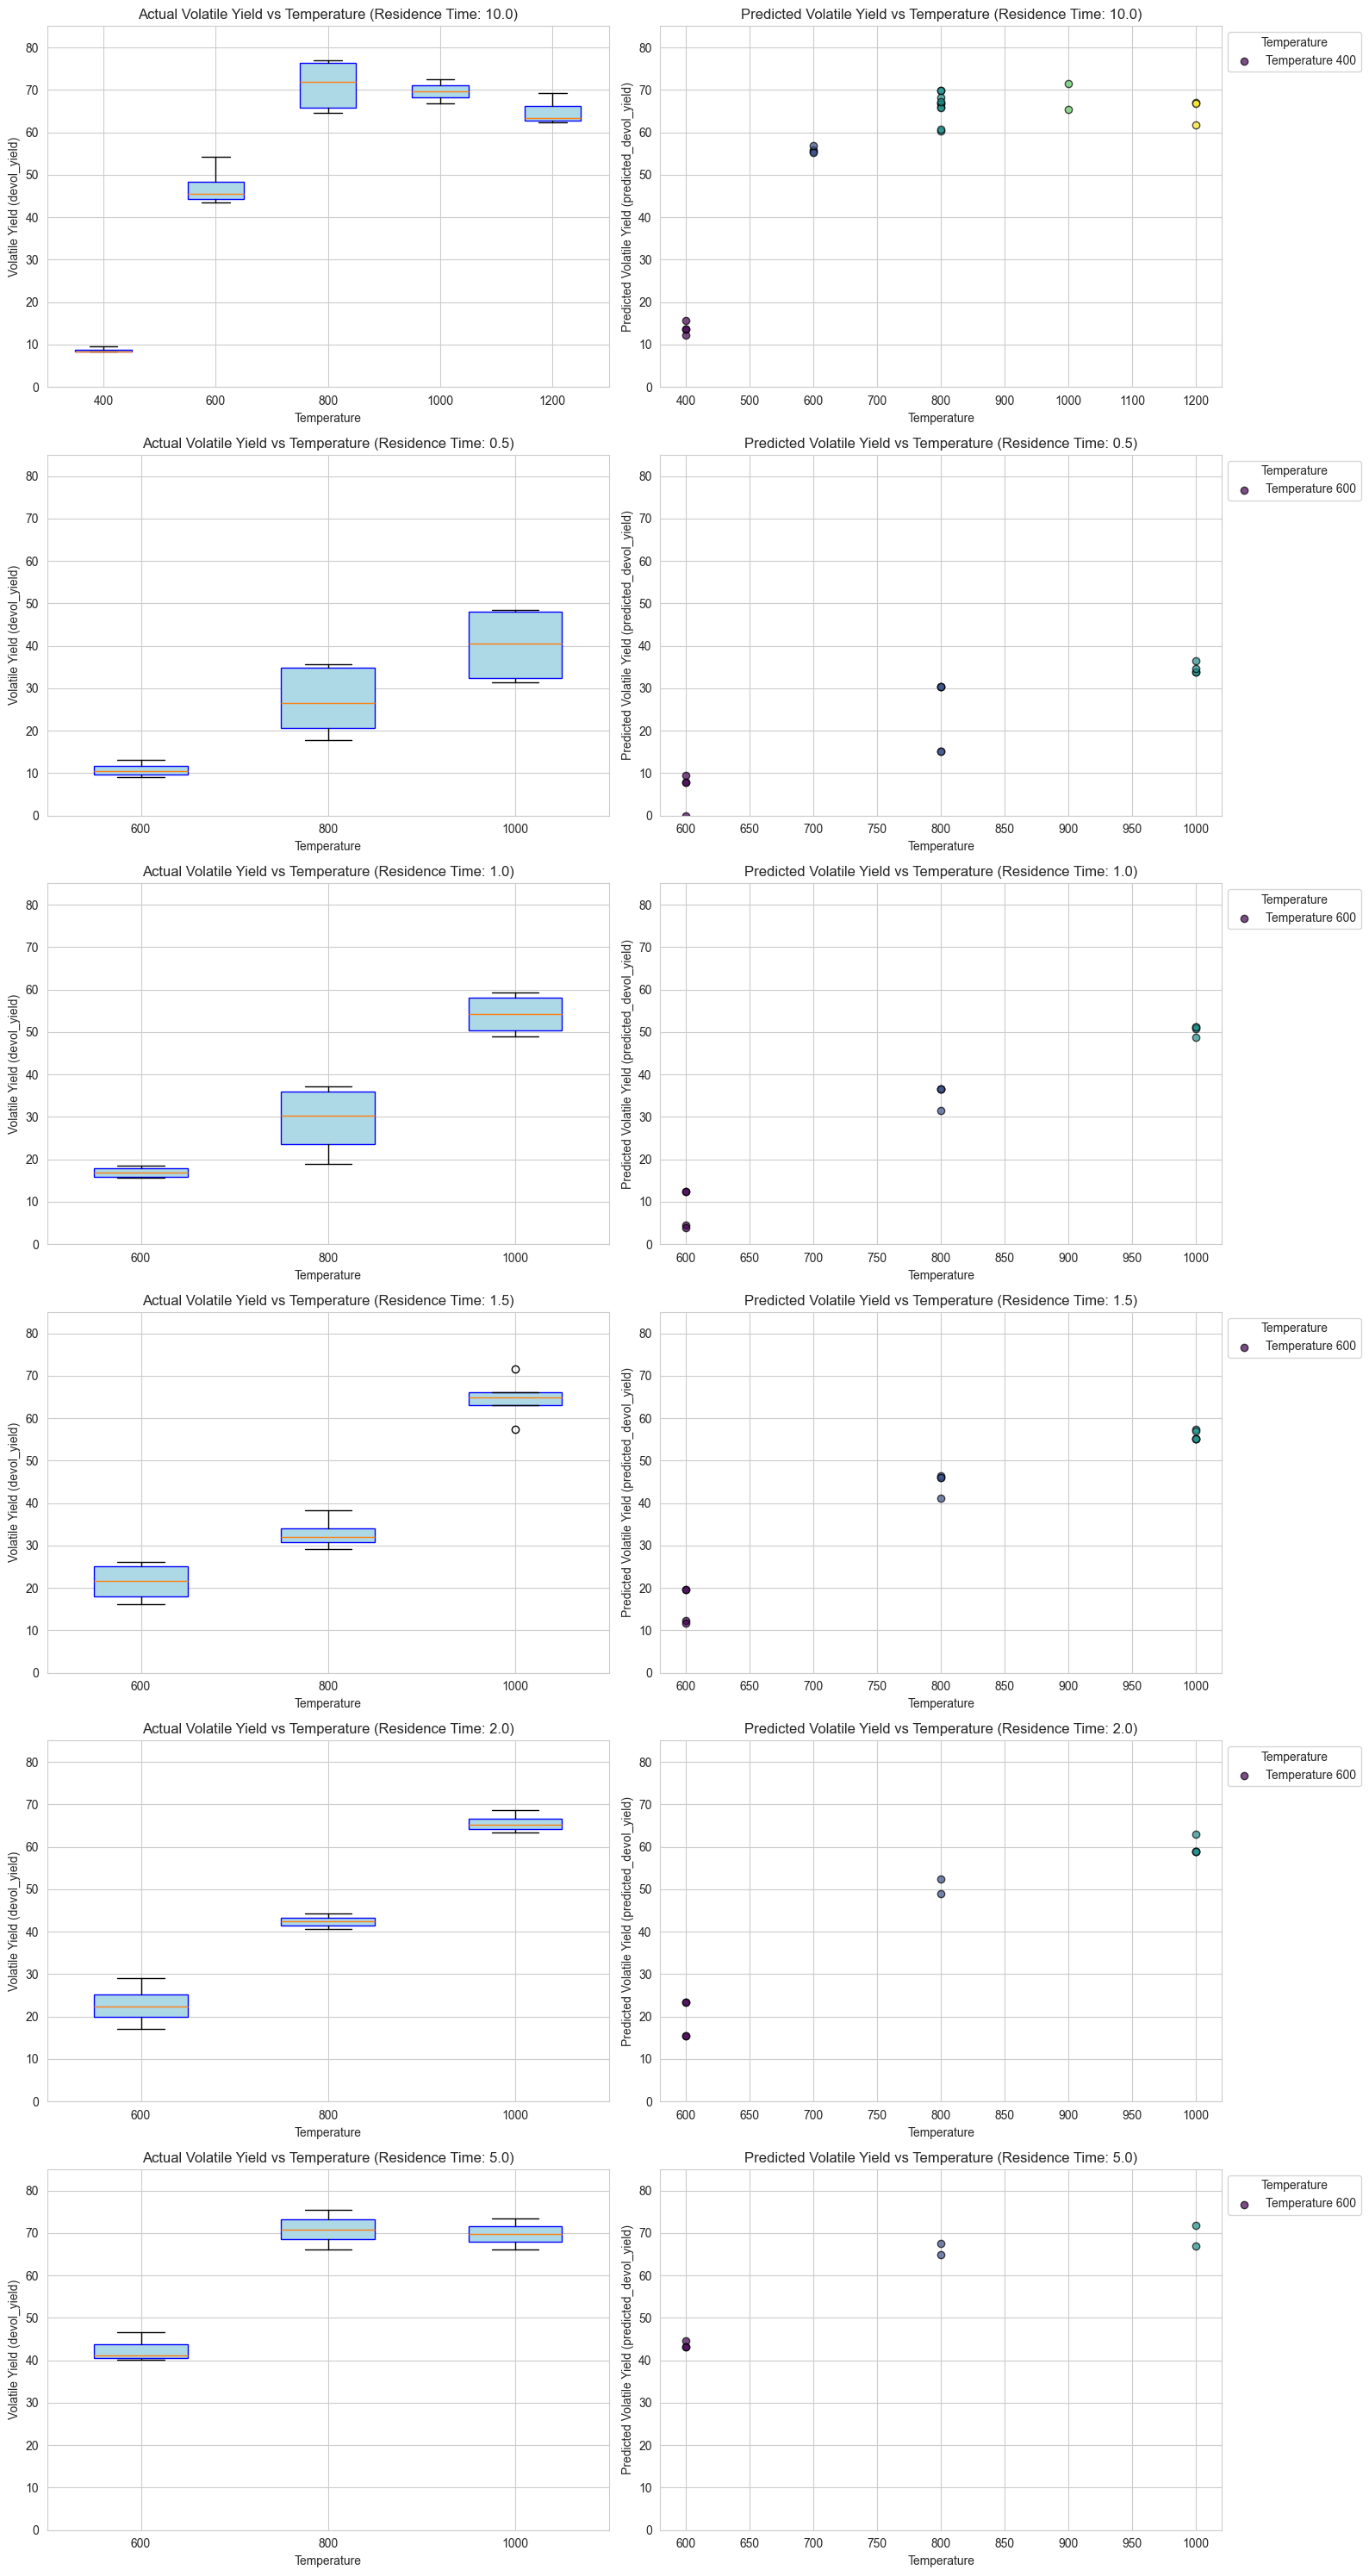

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique residence times
residence_times = test_data['residence_time'].unique()

# Create subplots for each residence_time value
fig, axes = plt.subplots(len(residence_times), 2, figsize=(16, 5 * len(residence_times)))

# Define a custom color palette for the temperature levels
colors = plt.cm.viridis(np.linspace(0, 1, len(test_data['temperature'].unique())))

# Loop over each unique residence_time and plot
for i, residence_time in enumerate(residence_times):
    # Filter the data for the current residence_time
    subset_actual = test_data[test_data['residence_time'] == residence_time]
    subset_predicted = test_data[test_data['residence_time'] == residence_time]

    # --- Plot Actual devol_yield as Box Plot ---
    # Create box plot for actual devol_yield
    axes[i, 0].boxplot([subset_actual[subset_actual['temperature'] == temp]['devol_yield'].values
                        for temp in subset_actual['temperature'].unique()],
                       positions=np.arange(len(subset_actual['temperature'].unique())),
                       widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))
    axes[i, 0].set_xticks(np.arange(len(subset_actual['temperature'].unique())))
    axes[i, 0].set_xticklabels(subset_actual['temperature'].unique())
    axes[i, 0].set_title(f'Actual Volatile Yield vs Temperature (Residence Time: {residence_time})')
    axes[i, 0].set_xlabel('Temperature')
    axes[i, 0].set_ylabel('Volatile Yield (devol_yield)')
    axes[i, 0].set_ylim(0, 85)  # Set y-axis from 0 to 85

    # --- Plot Predicted devol_yield as Scatter Plot ---
    # Create scatter plot for predicted devol_yield
    for j, temp in enumerate(subset_predicted['temperature'].unique()):
        temp_data = subset_predicted[subset_predicted['temperature'] == temp]
        axes[i, 1].scatter([temp] * len(temp_data), temp_data['predicted_devol_yield'],
                           color=colors[j], label=f'Temperature {temp}' if j == 0 else "", alpha=0.7, edgecolors='k')

    axes[i, 1].set_title(f'Predicted Volatile Yield vs Temperature (Residence Time: {residence_time})')
    axes[i, 1].set_xlabel('Temperature')
    axes[i, 1].set_ylabel('Predicted Volatile Yield (predicted_devol_yield)')
    axes[i, 1].legend(title="Temperature", loc='upper left', bbox_to_anchor=(1, 1))
    axes[i, 1].set_ylim(00, 85)  # Set y-axis from 0 to 85

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
